In [1]:
import cv2
import numpy as np
from numpy import random
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
(x_train,y_train),(x_test,y_test)=keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
minImg=24
maxImg=64
minInnerImg=20
def loadImage(image,imgSize):
  innerImgSize=(random.randint(minInnerImg,imgSize[0]),random.randint(minInnerImg,imgSize[1]))
  image=cv2.resize(image,(innerImgSize[1],innerImgSize[0]))
  BlankImg=np.zeros(imgSize)
  imageOffset=(random.randint(0,imgSize[0]-innerImgSize[0]),random.randint(0,imgSize[1]-innerImgSize[1]))
  BlankImg[imageOffset[0]:imageOffset[0]+innerImgSize[0],imageOffset[1]:imageOffset[1]+innerImgSize[1]]=image
  image=BlankImg
  image = image.astype("float32") / 255
  image = np.expand_dims(image, -1)
  return image

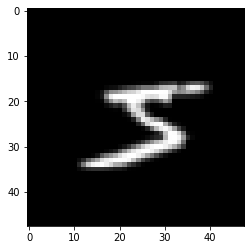

In [6]:
plt.imshow(loadImage(x_train[0],(48,48)).squeeze(),cmap="gray")

In [ ]:
num_classes=10

In [ ]:
from tensorflow.keras.utils import Sequence
class data_generator(Sequence):
  def __init__(self,input_images,lables,batch_size,shuffle=True):
    self.input_images = input_images
    self.lables = lables
    self.batch_size = batch_size
    self.indices = np.arange(len(self.input_images))
    self.shuffle=shuffle
  def __len__(self):
    return int(np.ceil(len(self.input_images)/float(self.batch_size)))

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indices = np.arange(len(self.input_images))
      if self.shuffle == True:
          np.random.shuffle(self.indices)

  
  def __getitem__(self,idx):
    inds=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
    batch_x = self.input_images[inds]
    batch_y = self.lables[inds]
    # Important images of each batch should have the same size
    imgSize=(random.randint(minImg,maxImg),random.randint(minImg,maxImg))

    return np.array([loadImage(image,imgSize) for image in batch_x]),np.array([keras.utils.to_categorical(y, num_classes) for y in batch_y])

In [ ]:
inputImg = layers.Input(shape=(None,None,1),name="inputLayer",dtype="float")
x=layers.Conv2D(16,(3,3),activation="relu",padding="same")(inputImg)
x=layers.AveragePooling2D((2,2))(x)
x=layers.BatchNormalization()(x)

x=layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
x=layers.AveragePooling2D((2,2))(x)
x=layers.BatchNormalization()(x)

x=layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
x=layers.AveragePooling2D((2,2))(x)
x=layers.BatchNormalization()(x)

x=layers.Conv2D(num_classes,(1,1),activation="relu",padding="same")(x)
x=layers.GlobalAveragePooling2D()(x)
#out=layers.Dense(num_classes,activation="softmax")(x)
out=layers.Activation("softmax")(x)

model = keras.Model(inputImg,out)
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    160       
_________________________________________________________________
average_pooling2d (AveragePo (None, None, None, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 16)    64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 32)    128   

In [ ]:
batch_size = 120
epochs=50

validation_percentage=0.2

train_images=x_train[0:int(len(x_train)*(1-validation_percentage))]
validation_images=x_train[int(len(x_train)*(1-validation_percentage)):len(x_train)-1]

train_gt=y_train[0:int(len(x_train)*(1-validation_percentage))]
validation_gt=y_train[int(len(x_train)*(1-validation_percentage)):len(x_train)-1]

training_batch_generator=data_generator(train_images,train_gt,batch_size)
validation_batch_generator=data_generator(validation_images,validation_gt,batch_size)
num_training_samples=len(train_images)
num_validation_samples=len(validation_images)

checkpoint = keras.callbacks.ModelCheckpoint("model-{epoch:03d}-{accuracy}-{val_accuracy}.h5",save_best_only=True,monitor="val_accuracy")


model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch = (num_training_samples//batch_size),
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=(num_validation_samples //batch_size),
                    use_multiprocessing=True,
                    workers=16,
                    max_queue_size=32,
                    shuffle=True,
                    callbacks=checkpoint)



Epoch 1/50


/home/reza/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


400/400 [==============================] - 9s 16ms/step - loss: 1.3879 - accuracy: 0.6029 - val_loss: 10.2545 - val_accuracy: 0.0997
Epoch 2/50
400/400 [==============================] - 7s 14ms/step - loss: 0.2988 - accuracy: 0.9413 - val_loss: 2.9516 - val_accuracy: 0.3654
Epoch 3/50
400/400 [==============================] - 7s 14ms/step - loss: 0.1705 - accuracy: 0.9623 - val_loss: 0.5550 - val_accuracy: 0.8269
Epoch 4/50
400/400 [==============================] - 7s 14ms/step - loss: 0.1208 - accuracy: 0.9704 - val_loss: 1.1621 - val_accuracy: 0.6561
Epoch 5/50
400/400 [==============================] - 8s 15ms/step - loss: 0.0969 - accuracy: 0.9757 - val_loss: 0.2133 - val_accuracy: 0.9332
Epoch 6/50
400/400 [==============================] - 7s 14ms/step - loss: 0.0904 - accuracy: 0.9767 - val_loss: 0.4413 - val_accuracy: 0.8405
Epoch 7/50
400/400 [==============================] - 7s 13ms/step - loss: 0.0756 - accuracy: 0.9787 - val_loss: 0.3411 - val_accuracy: 0.8934
Epoch 8/5

In [ ]:
predictionModel = keras.models.load_model("model-044-0.9919583201408386-0.9914141297340393.h5")

In [ ]:
selection = 35
pred =  np.argmax(predictionModel.predict(x_train[:selection]),axis=1)
upScale48=[]
for i in range(selection):
    img=cv2.resize(x_train[i],(48,48))
    upScale48.append(img)
upScale48 = np.array(upScale48)
predUpScale48 = np.argmax(predictionModel.predict(upScale48),axis=1)
print("original          :",pred)
print("scaled to (48,48) :",predUpScale48)

original          : [7 0 4 7 9 2 1 3 1 4 3 5 3 6 7 7 2 8 6 7 2 0 7 7 1 2 4 3 2 7 3 8 6 7 0]
scaled to (48,48) : [7 0 7 1 7 2 1 7 1 7 2 5 2 6 7 7 2 2 6 7 2 0 7 1 4 7 7 2 2 7 7 0 6 7 7]
